In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/keerthanavenkatesan/Documents/Data Managment/CS210FinalProject/Spotify_Popularity_Prediction/data/cleaned/spotify_cleaned.csv")

print("SHAPE:", df.shape)
print("\nCOLUMNS:\n", list(df.columns))
print("\nDTYPES:\n", df.dtypes)
print(df.head())


SHAPE: (99742, 16)

COLUMNS:
 ['popularity', 'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

DTYPES:
 popularity            int64
year                  int64
genre                object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object
   popularity  year      genre  danceability  energy  key  loudness  mode  \
0          38  2006   alt-rock         0.725   0.553    6    -6.319     0   
1          11  2023    swedish         0.277   0.164    9   -16.743     0   
2          38  2007   alt-rock         0.486   0.927    2    -4.84

X shape: (99742, 15)
y shape: (99742,)

Target (popularity) stats:
count    99742.000000
mean        18.547904
std         15.931685
min          0.000000
25%          5.000000
50%         15.000000
75%         29.000000
max         93.000000
Name: popularity, dtype: float64


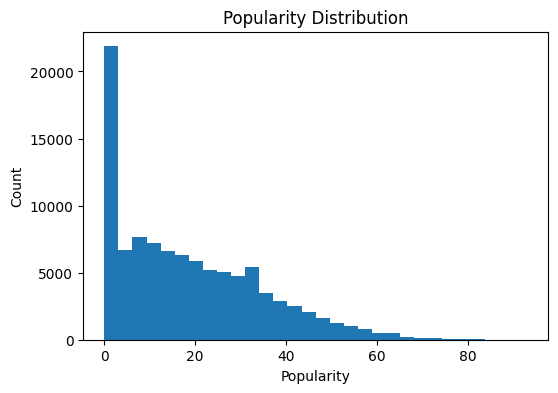


Train shapes: (79793, 15) (79793,)
Test shapes: (19949, 15) (19949,)


In [2]:
X = df.drop("popularity", axis=1)
y = df["popularity"]

print("X shape:", X.shape)
print("y shape:", y.shape)

print("\nTarget (popularity) stats:")
print(y.describe())

plt.figure(figsize=(6,4))
plt.hist(y, bins=30)
plt.title("Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


In [4]:
df_encoded = pd.get_dummies(df, columns=['genre'], drop_first=True)
df_encoded.shape

(99742, 96)

In [5]:
X = df_encoded.drop('popularity', axis=1)
y = df_encoded['popularity']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((79793, 95), (19949, 95))

In [6]:
numeric_cols = [
    'year', 'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'duration_ms', 'time_signature'
]

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

mse, r2

(115.7252217554167, 0.5500771747930346)

In [8]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

rf_mse, rf_r2

(96.49070524698095, 0.6248581765288153)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)

gb_preds = gb.predict(X_test)

gb_mse = mean_squared_error(y_test, gb_preds)
gb_r2 = r2_score(y_test, gb_preds)

gb_mse, gb_r2


(120.58864796292424, 0.5311688812829816)

In [11]:
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingRegressor()

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4],
}

grid = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV MSE:", -grid.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best CV MSE: 104.29761816082386


In [12]:
gb_tuned = grid.best_estimator_

gb_tuned_preds = gb_tuned.predict(X_test)

gb_tuned_mse = mean_squared_error(y_test, gb_tuned_preds)
gb_tuned_r2 = r2_score(y_test, gb_tuned_preds)

print("Tuned GBDT Test MSE:", gb_tuned_mse)
print("Tuned GBDT Test R²:", gb_tuned_r2)


Tuned GBDT Test MSE: 104.23000541959745
Tuned GBDT Test R²: 0.5947689034561943


In [13]:
ensemble_preds = (rf_preds + gb_tuned_preds) / 2
ens_mse = mean_squared_error(y_test, ensemble_preds)
ens_r2 = r2_score(y_test, ensemble_preds)

print("Ensemble MSE:", ens_mse)
print("Ensemble R²:", ens_r2)

Ensemble MSE: 96.13913305821603
Ensemble R²: 0.6262250380481444


Final Model Choice Summary

Models evaluated:

Linear Regression

Random Forest

Gradient Boosting Regressor

Tuned Gradient Boosting Regressor

RF + GBDT Ensemble

Best Model:
The ensemble model combining Random Forest and Tuned Gradient Boosting performed the best.

Final Metrics:

MSE: 96.14

R²: 0.626

This means the model explains ~62.6% of the variance in song popularity.
Given the large dataset and so many values, this model performed fairly well within in the noise created by data points.